# Conditional Generative Adversarial Networks (cGANs)

**Learning Objectives**

- Build a Conditional GAN architecture (consisting of a generator and discriminator) in Keras 
- Define the loss for the generator and discriminator
- Define a training step for the GAN using tf.keras.Model subcrassing
- Train the cGAN on the MNIST dataset

## Introduction
This notebook demonstrates how to build and train a [Conditional Generative Adversarial Network](https://arxiv.org/abs/1411.1784).

The basic GAN that we discussed in the previous lab([deepconv-gan.ipynb](./deepconv_gan.ipynb)) is trained in a completely unsupervised way on images that we want to learn how to generate. <br>
Latent representations, such as a random noise vector, are then used to explore and sample the learned image space.

A simple enhancement is to add an external flag to our inputs with a label.<br>
For instance, consider the MNIST dataset, which consists of handwritten digits from 0 to 9. 

Normally, the GAN just learns the distribution of digits, and when the generator is given random noise vectors, it generates different digits.

![Basic GAN](https://user-images.githubusercontent.com/6895245/171208971-3ff1c023-cdd7-47c2-b734-77e07b8eb6ac.png)

However, which digit are generated cannot be controlled.

During training, as with MNIST, we may know the actual digit or class designation for each image. <br>
That extra information can be included as a feature in our GAN training that can then be used at inference time. 

With conditional GANs (cGANs), image generation can be conditional on the digit, so we are able to home in on the specific digit of interest’s distribution. 

Then, at inference time we can create an image of a specific digit by passing in the desired digit instead of receiving a random digit.

![cGAN](https://user-images.githubusercontent.com/6895245/171209451-4b95c856-fafa-40b4-87b6-c7232c1de841.png)

In this notebook, you are going to learn how to build conditional GAN.

## Import TensorFlow and other libraries

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Embedding,
    Input,
    LeakyReLU,
    Reshape,
)

## Constants

In [2]:
IMAGE_SHAPE = (28, 28, 1)
NUM_CLASSES = 10
LATENT_DIM = 512
PROJECTION_SHAPE = (7, 7, 56)

## Create the generator and discriminator models for Conditional GAN

In the previous lab, vanilla GAN was defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model), but here we use [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) to create more complicated models for Conditional GAN.

Firstly, we need to define layers to embed digit (0-9) information, which will be used both in Generator and Discriminator.<br>
The embedding should be a rank 3 tensor (height, width, 1) like an image so that it can be concatenated with the mnist image later.

In [3]:
def create_digit_embedding(digits, num_classes, embedding_dim, image_shape):

    embedded_digits = Embedding(
        name="digit_embedding", input_dim=num_classes, output_dim=embedding_dim
    )(digits)

    num_pixels = image_shape[0] * image_shape[1]  # height * width

    dense_digits = Dense(name="digit_dense", units=num_pixels)(embedded_digits)

    digits_image = Reshape(
        name="digit_to_image_reshape",
        target_shape=(image_shape[0], image_shape[1], 1),
    )(dense_digits)

    return digits_image

Let's try to generate a digit embedding image. Since it is not trained yet, still it is just a random noise image.

2022-07-27 10:54:20.766959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 10:54:20.777183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 10:54:20.777850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 10:54:20.779355: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

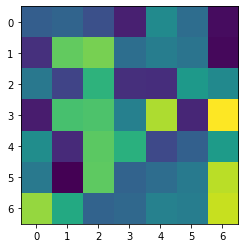

In [4]:
DIGIT_TO_EMBED = 0  # [0,9]

digit_embedding = create_digit_embedding(
    tf.convert_to_tensor([DIGIT_TO_EMBED]), NUM_CLASSES, 128, (7, 7, 1)
)[0]
plt.imshow(digit_embedding)

### The Generator

The generator of Conditional GAN creates images from random latent vectors and digit vectors.

The generator model uses [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) to upsample images usually along with [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization). Also it uses [LeakyRelu](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) for a nonlinear activation.



Now we define the function `create_dcgan_generator` to build a cGAN generator. This will:

1. map a latent vector to a rank-3 tensor.
2. map a digit index to rank-3 tensors (call `create_digit_embedding` function)
3. concatenate 1 and 2
4. pass 3 to GAN generator that has blocks consisting of `Conv2DTranspose`, `BatchNormalization` and `LeakyRelu` layer. Note that this part is almost the same as the DCGAN generator from the previous notebook.
5. return a Model object

In [5]:
def create_dcgan_generator(latent_dim, num_classes, projection_shape):

    # Random vector input
    latent_vector = Input(name="latent_input", shape=(latent_dim,))

    num_image_pixel = (
        projection_shape[0] * projection_shape[1] * projection_shape[2]
    )

    x = Dense(name="latent_dense", units=num_image_pixel)(latent_vector)
    x = LeakyReLU(name="latent_leakyrelu", alpha=0.2)(x)

    latent_image = Reshape(
        name="latent_to_image_reshape", target_shape=projection_shape
    )(x)

    # Receive digit inputs ([0,9])
    digits = Input(name="digit_input", shape=())
    # Project digits to rank 3 tensor digit embeddings.
    digit_embeddings = create_digit_embedding(
        digits=digits,
        num_classes=num_classes,
        embedding_dim=50,
        image_shape=projection_shape,
    )

    concatenated_inputs = Concatenate(name="concatenate_latent_digit", axis=-1)(
        inputs=[latent_image, digit_embeddings]
    )

    x = Conv2DTranspose(128, 4, 2, "same")(concatenated_inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128, 4, 2, "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    outputs = Conv2DTranspose(
        1,
        3,
        1,
        "same",
        activation="tanh",
        name="generator_output",
    )(x)

    return tf.keras.Model(
        inputs=[latent_vector, digits], outputs=outputs, name="dcgan_generator"
    )

In [6]:
dcgan_generator = create_dcgan_generator(
    latent_dim=LATENT_DIM,
    num_classes=NUM_CLASSES,
    projection_shape=PROJECTION_SHAPE,
)
dcgan_generator.summary()

Model: "dcgan_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_input (InputLayer)      [(None, 512)]        0           []                               
                                                                                                  
 digit_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 latent_dense (Dense)           (None, 2744)         1407672     ['latent_input[0][0]']           
                                                                                                  
 digit_embedding (Embedding)    (None, 50)           500         ['digit_input[0][0]']            
                                                                                    

Let's plot the generator model and check how it is built.

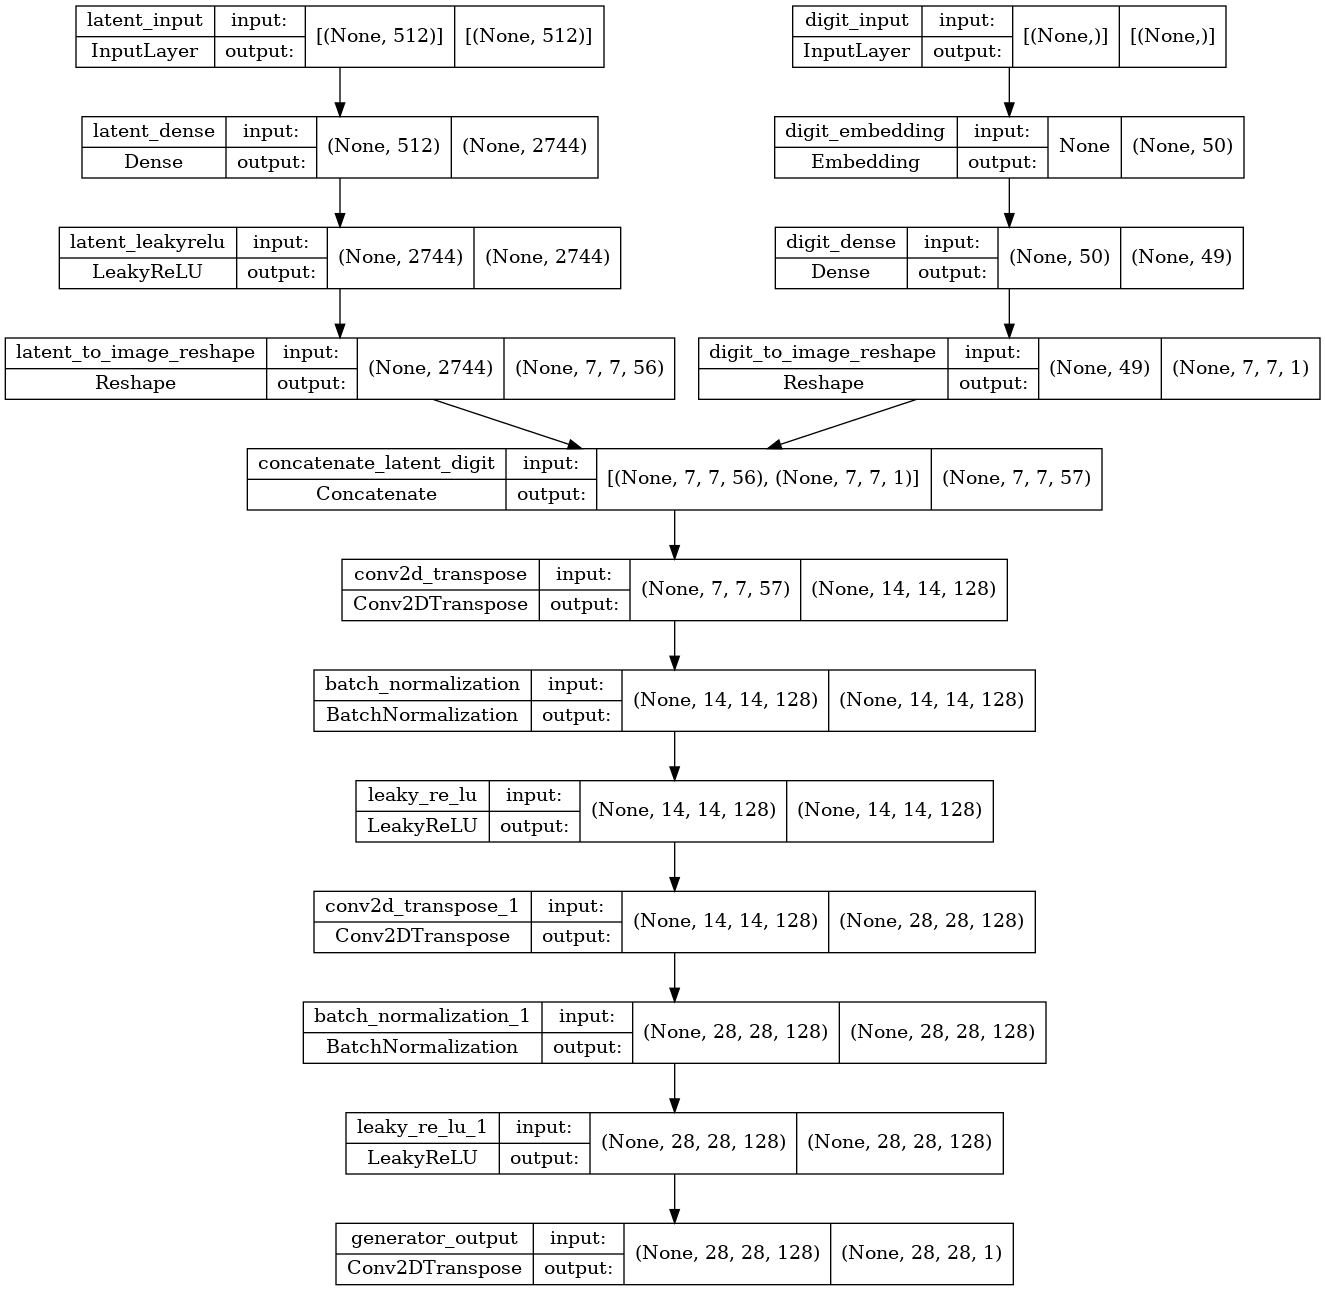

In [7]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=dcgan_generator, show_shapes=True, show_layer_names=True
)

### The Discriminator

Next, we will build the discriminator. The discriminator is a CNN-based image classifier. <br>
It should take in an image of shape 28x28x1 and digit represented in 28x28x1, and return a single classification indicating if that image is real or not.

Let's define the function `create_dcgan_discriminator` to build a cGAN discriminator. This will:

1. receive an image input, which can be real or fake.
2. map a digit index to rank-3 tensors (call `create_digit_embedding` function)
3. concatenate 1 and 2
4. pass 3 to GAN generator that has blocks consisting of `Conv2D`, `BatchNormalization` and `LeakyRelu` layer. Note that this part is almost the same as the DCGAN discriminator from the previous notebook.
5. return a Model object


In [8]:
def create_dcgan_discriminator(image_shape, num_classes):

    images = tf.keras.Input(name="image_input", shape=image_shape)

    digits = tf.keras.Input(name="digit_input", shape=())
    digit_embeddings = create_digit_embedding(
        digits=digits,
        num_classes=num_classes,
        embedding_dim=50,
        image_shape=image_shape,
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        name="concatenate_image_digit", axis=-1
    )(inputs=[images, digit_embeddings])

    x = Conv2D(64, 3, 1, "same")(concatenated_inputs)

    x = Conv2D(128, 3, 2, "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, 3, 2, "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, 3, 2, "same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Flatten()(inputs=x)
    outputs = tf.keras.layers.Dense(name="discriminator_output", units=1)(x)

    return tf.keras.Model(
        inputs=[images, digits], outputs=outputs, name="dcgan_discriminator"
    )

In [9]:
dcgan_discriminator = create_dcgan_discriminator(
    image_shape=IMAGE_SHAPE, num_classes=NUM_CLASSES
)
dcgan_discriminator.summary()

Model: "dcgan_discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 digit_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 digit_embedding (Embedding)    (None, 50)           500         ['digit_input[0][0]']            
                                                                                                  
 digit_dense (Dense)            (None, 784)          39984       ['digit_embedding[0][0]']        
                                                                                                  
 image_input (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                

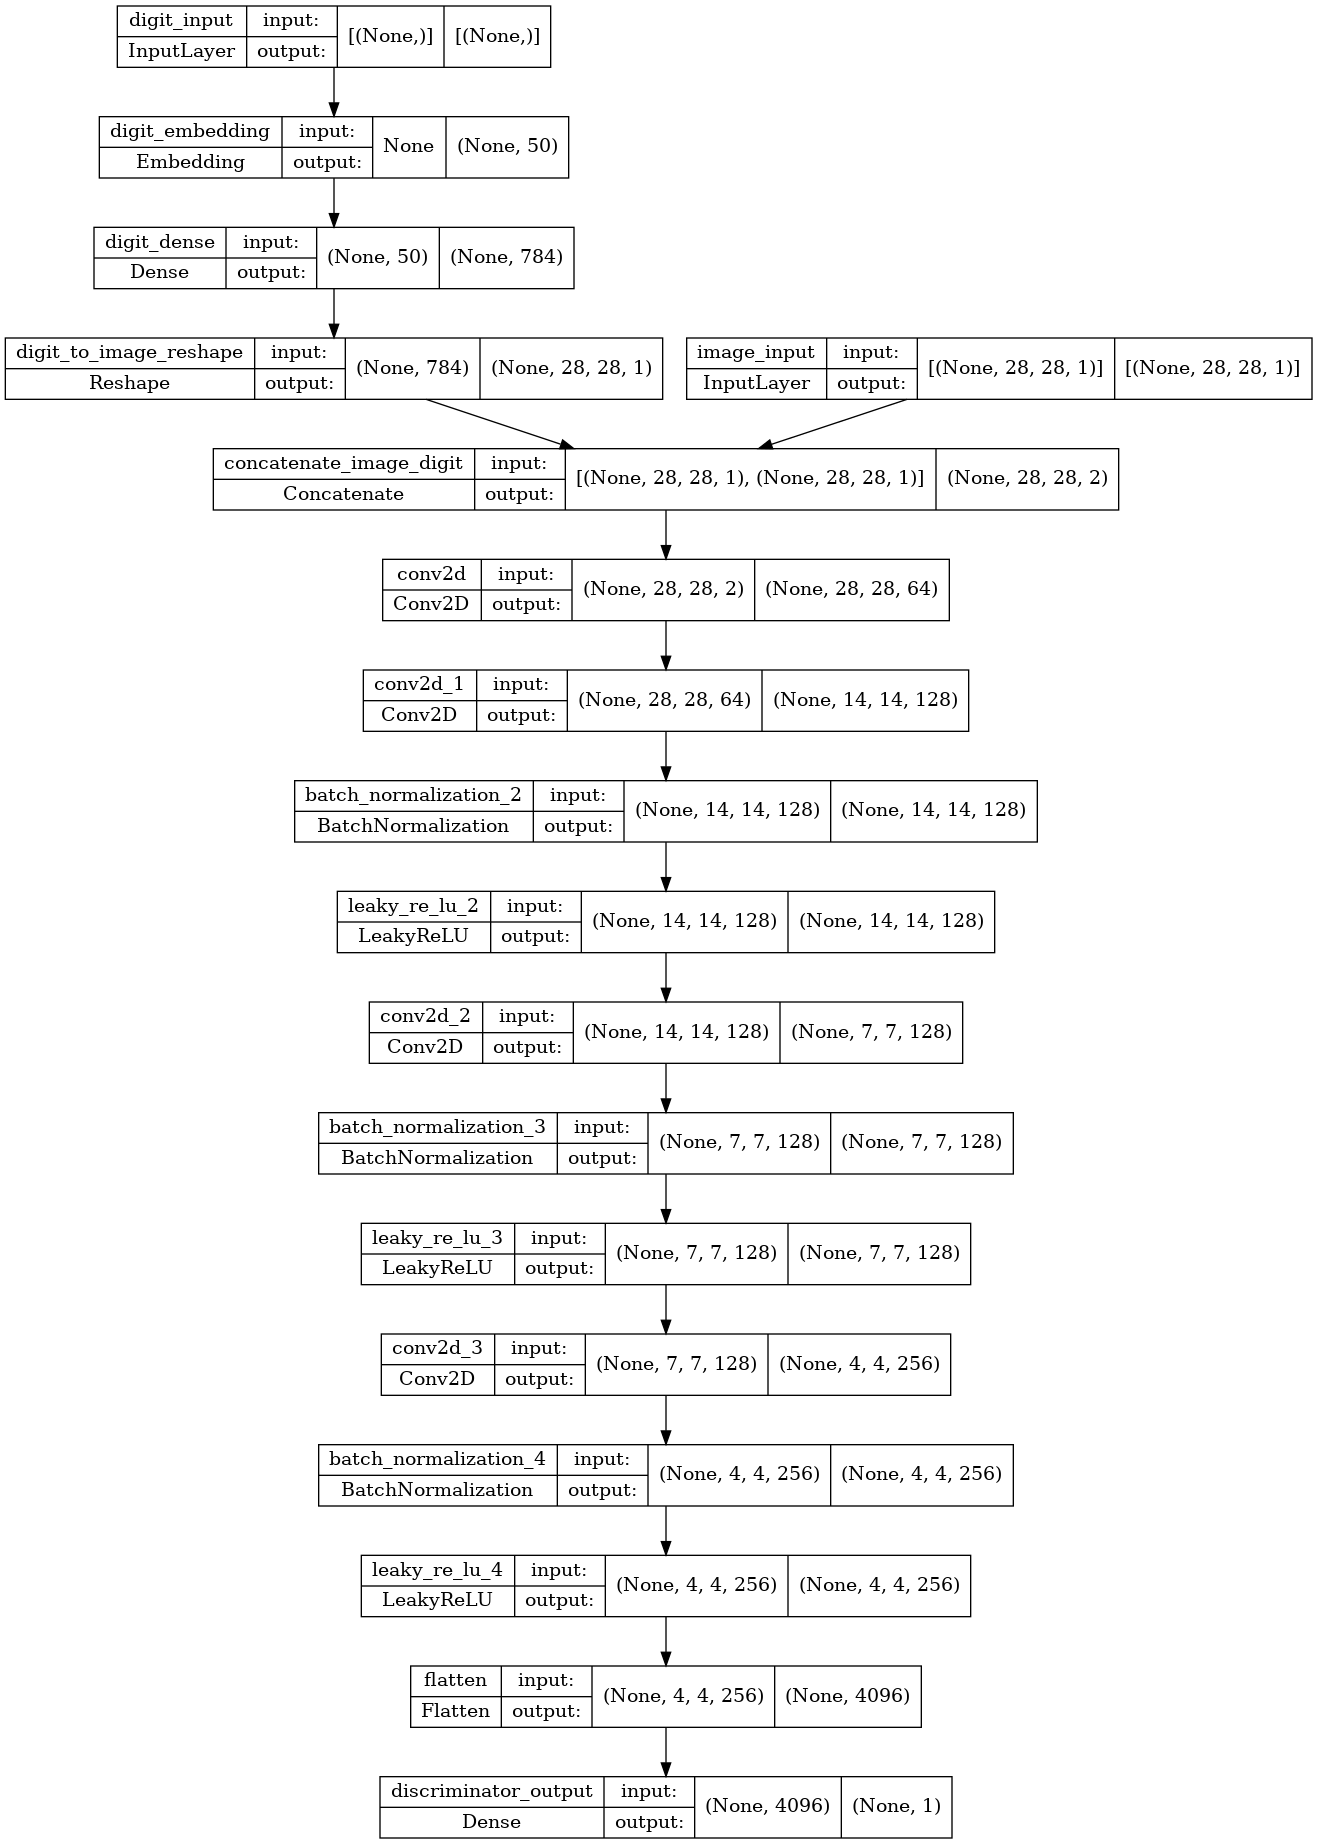

In [10]:
# Plot discriminator model.
tf.keras.utils.plot_model(
    model=dcgan_discriminator, show_shapes=True, show_layer_names=True
)

We'll create a custom `Model` class named `GAN` that we can use to facilitate training of our generator and discriminator networks.

### Define GAN class
Now we have the generator and the discriminator model.

Let's combine them into a class by subclassing [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

By defining our own model class, we can use the standard model APIs like `model.fit()` by defining the original training steps and `model.save()` to save a model object in TensorFlow saved model format easily. Also, we can override the functions of tf.keras.Model to change behaviors of our model.

Here we define these functions in our Conditional_GAN class:
- `__init__()`: instantiates model class. Here we pass the generator and discriminator that we defined above. Also, note that we specify `one_sided_label_smoothing` constant here that is used in discriminator training.
- `compile()`: overrides the `Model.compile()` function to be able to define optimizers of a generator and a discriminator separately, and to add a loss function that is used in both models.
- `discriminator_train_step()`: defines a discriminator specific training step. It has multiple steps:
    1. Sample random points in the latent space.
    2. Generate images from noise from random vectors created in step 1.
    3. Create training features by combining generated images with real images.
    4. Create labels for generated images (0) and real images (1). Here we apply **one-sided label smoothing** to real labels. Refer to the description of one-sided label smoothing below
    5. in a `tf.GradientTape` context, call the discriminator to get predictions and compute loss.
    6. Get gradients of the parameters of the discriminator from `GradientTape` and update them. Note that the generator is not updated in the discriminator training step.
- `generator_train_step()`: defines a generator specific training step
    1. Sample random points in the latent space.
    2. Create labels for generated images (1) as if they're real images.
    3. in a `tf.GradientTape` context, call the generator to generate images, pass them to the discriminator, and compute loss using labels created in step 2.
    4. Get gradients of the parameters of the generator from `GradientTape` and update them. Note that the discriminator is not updated in the discriminator training step.

- `train_step()`: overrides `Model.train_step` where we can define an custom training step. Here we call `discriminator_train_step` and `generator_train_step` in order to train a discriminator and a generator sequentially, and return two losses of two models.

**one-sided label smoothing**: To multiply real labels (1) by a float constant in the range [0.0, 1.0] to help the discriminator avoid becoming overconfident in its predictions based on only a small set of features within the images, which the generator may then exploit (causing it to become good at beating the discriminator but not at image generation).

In [11]:
class Conditional_GAN(tf.keras.Model):
    def __init__(
        self, discriminator, generator, latent_dim, one_sided_label_smoothing
    ):

        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.one_sided_label_smoothing = one_sided_label_smoothing

    def compile(self, discriminator_optimizer, generator_optimizer, loss_fn):

        super().compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn

    def discriminator_train_step(self, batch_size, real_images, input_digits):

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Generate images from noise.
        generated_images = self.generator(
            inputs=[random_latent_vectors, input_digits]
        )

        # Combine generated images with real images.
        combined_images = tf.concat(
            values=[generated_images, real_images], axis=0
        )

        # Create fake and real labels.
        fake_labels = tf.zeros(shape=(batch_size, 1))
        real_labels = tf.ones(shape=(batch_size, 1))

        # Smooth real labels to help with training.
        real_labels *= self.one_sided_label_smoothing

        # Combine labels to be in-line with combined images.
        labels = tf.concat(values=[fake_labels, real_labels], axis=0)

        # Train ONLY the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                inputs=[
                    combined_images,
                    tf.concat(values=[input_digits, input_digits], axis=0),
                ]
            )
            discriminator_loss = self.loss_fn(y_true=labels, y_pred=predictions)

        grads = tape.gradient(
            target=discriminator_loss,
            sources=self.discriminator.trainable_weights,
        )

        self.discriminator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.discriminator.trainable_weights)
        )

        return discriminator_loss

    def generator_train_step(self, batch_size, input_digits):

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Create labels as if they're real images.
        labels = tf.ones(shape=(batch_size, 1))

        # Train ONLY the generator.
        with tf.GradientTape() as tape:
            fake_images = self.generator(
                inputs=[random_latent_vectors, input_digits]
            )
            predictions = self.discriminator(inputs=[fake_images, input_digits])
            generator_loss = self.loss_fn(y_true=labels, y_pred=predictions)

        grads = tape.gradient(
            target=generator_loss, sources=self.generator.trainable_weights
        )

        self.generator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.generator.trainable_weights)
        )

        return generator_loss

    def train_step(self, features):

        real_images = features["images"]
        input_digits = features["digits"]

        # Get dynamic batch size to use for random noise vectors.
        batch_size = tf.shape(input=real_images)[0]

        # First train discriminator.
        discriminator_loss = self.discriminator_train_step(
            batch_size, real_images, input_digits
        )

        # Then train generator.
        generator_loss = self.generator_train_step(batch_size, input_digits)

        losses = {
            "discriminator_loss": discriminator_loss,
            "generator_loss": generator_loss,
        }

        return losses

We can instantiate the Conditional GAN model and compile it.

Please note that instantiaion calls `__init__` function and complilation does `compile` function of `Conditional_GAN` class.

In [12]:
# Instantiate a Conditional_GAN instance using our DCGAN generator and discriminator.
dcgan = Conditional_GAN(
    discriminator=dcgan_discriminator,
    generator=dcgan_generator,
    latent_dim=LATENT_DIM,
    one_sided_label_smoothing=0.9,
)

dcgan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

## Create input data pipeline with tf.data
Now our model is ready. Let's create a data pipeline with tf data. <br>
Note that we have to pass not only images but also labels to CGAN.


In [13]:
def create_train_dataset(batch_size):

    # Get and format MNIST data.
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Let's combine both training and test sets.
    combined_images = np.concatenate([x_train, x_test])
    combined_images = (combined_images.astype("float32") - 127.5) / 255.0
    combined_images = np.reshape(combined_images, newshape=(-1, 28, 28, 1))

    combined_labels = np.concatenate([y_train, y_test])

    # Create tf.data.Dataset for training.
    dataset = tf.data.Dataset.from_tensor_slices(
        tensors={"images": combined_images, "digits": combined_labels}
    )
    dataset = dataset.shuffle(buffer_size=70000).batch(batch_size=batch_size)

    return dataset

## Train CGAN
We can train a model by simply calling `model.fit()`. <br>
It take around 7 minutes with a GPU (NVIDIA T4) to train 10 epochs.

In [14]:
BATCH_SIZE = 128
EPOCHS = 10  # Change numbers for better generation

# Train DCGAN model.
dcgan_history = dcgan.fit(
    create_train_dataset(batch_size=BATCH_SIZE), epochs=EPOCHS
)

Epoch 1/10


2022-07-27 10:54:26.468398: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


547/547 [==============================] - 44s 72ms/step - discriminator_loss: 0.5399 - generator_loss: 1.3340
Epoch 2/10
547/547 [==============================] - 39s 70ms/step - discriminator_loss: 0.4298 - generator_loss: 1.9508
Epoch 3/10
547/547 [==============================] - 38s 70ms/step - discriminator_loss: 0.4072 - generator_loss: 2.1254
Epoch 4/10
547/547 [==============================] - 39s 70ms/step - discriminator_loss: 0.4067 - generator_loss: 2.1001
Epoch 5/10
547/547 [==============================] - 38s 70ms/step - discriminator_loss: 0.3996 - generator_loss: 2.1832
Epoch 6/10
547/547 [==============================] - 38s 70ms/step - discriminator_loss: 0.3936 - generator_loss: 2.2395
Epoch 7/10
547/547 [==============================] - 38s 70ms/step - discriminator_loss: 0.3896 - generator_loss: 2.2780
Epoch 8/10
547/547 [==============================] - 38s 70ms/step - discriminator_loss: 0.3778 - generator_loss: 2.3685
Epoch 9/10
547/547 [===============

Let's plot the loss history and some generated images using our trained model.

In [15]:
def plot_loss_history(history):
    """Plots loss history.

    Args:
        history: `keras.callbacks.History`, history object from training job.
    """
    plt.plot(history.history["generator_loss"])
    plt.plot(history.history["discriminator_loss"])
    plt.title("Training losses")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["generator", "discriminator"], loc="upper left")
    plt.show()

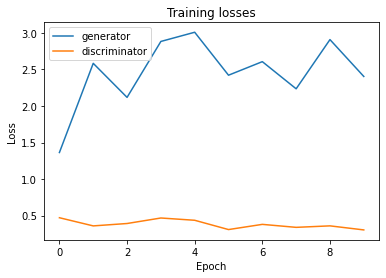

In [16]:
plot_loss_history(history=dcgan_history)

## Generate images
Now our CGAN is ready to generate images. Note that we can specify which number we want our generator to generate.

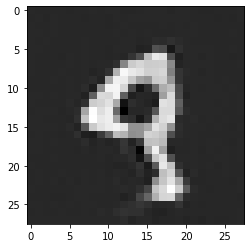

In [17]:
LABEL_TO_GENERATE = 9  # 0-9
latent_vectors = tf.random.normal(shape=(1, LATENT_DIM))

generated_image = dcgan.generator(
    inputs=[latent_vectors, tf.constant([LABEL_TO_GENERATE], dtype=tf.int32)]
)
plt.imshow(
    tf.reshape(generated_image, generated_image.shape[1:-1]), cmap="gray"
)

Let's try to generate multiple numbers.

This is a helper function to visualize multiple images.

In [18]:
def plot_images(images):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(tf.reshape(image, image.shape[:-1]), cmap="gray")
    plt.show()

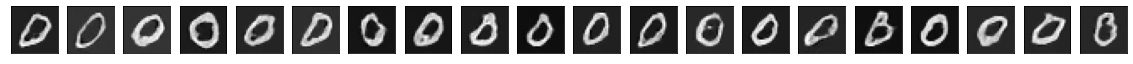

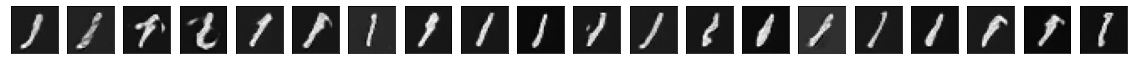

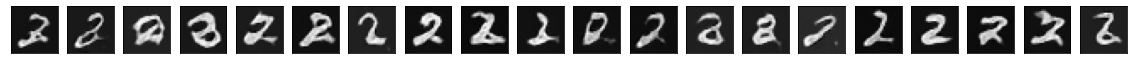

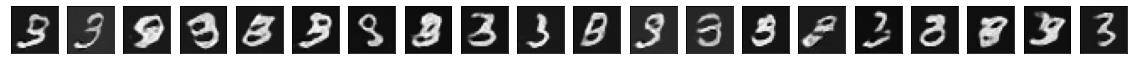

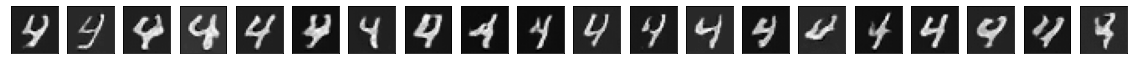

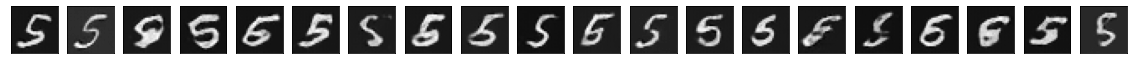

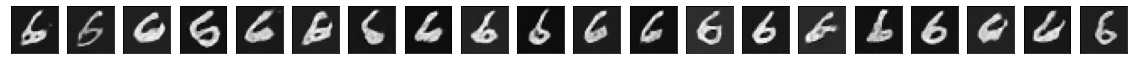

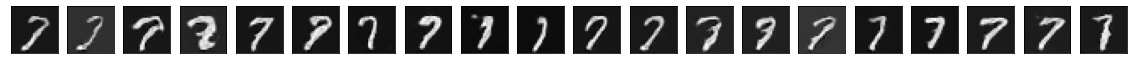

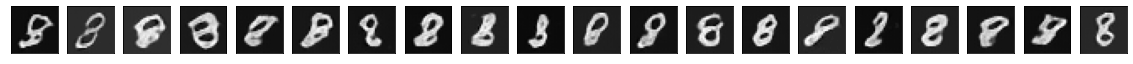

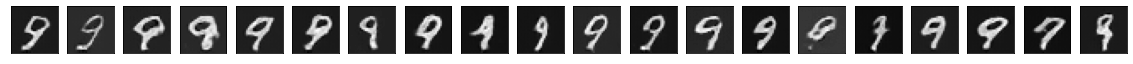

In [19]:
num_examples = 20
latent_vectors = tf.random.normal(shape=(num_examples, LATENT_DIM))
for i in range(10):
    labels = tf.ones(shape=num_examples, dtype=tf.int32) * i
    plot_images(images=dcgan.generator(inputs=[latent_vectors, labels]))

Looks good! You can try to get better images by specifying larger epochs (like 50).

## Summary
In this notebook, we learned how to build and train a Conditional GAN model.


Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License